In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
def list_classes_and_count(dataset_dir):
    classes = set()
    class_count = 0
    for root, dirs, files in os.walk(dataset_dir):
        for dir in dirs:
            classes.add(dir)
            class_count += 1
    return classes, class_count


# Directory paths for the two datasets
dataset_dir = "Plant Disease Recognition Dataset"

# List classes and count in each dataset
dataset_classes, dataset_classes = list_classes_and_count(dataset_dir + "/train")

print(f"Classes in New Plant Diseases Dataset: {dataset_classes}")

Classes in New Plant Diseases Dataset: 3


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generators for both datasets with augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
)

In [4]:
# from tensorflow.keras.preprocessing import image

# # Define an image path (replace this with an actual image path from your dataset)
# image_path = "Plant Disease Recognition Dataset/Valid/Healthy/9bd4cc8c52e9d52a.jpg"

# # Load and preprocess a single image for augmentation
# img = image.load_img(image_path, target_size=(128, 128))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)

# # Generate augmented images
# augmented_images = []
# for _ in range(9):  # Generate 9 augmented images for visualization
#     augmented_img = datagen.flow(x, batch_size=1)[0][0]
#     augmented_images.append(augmented_img)

# # Display the augmented images
# plt.figure(figsize=(8, 8))
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[i])
#     plt.axis("off")

# plt.tight_layout()
# plt.show()

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = datagen.flow_from_directory(
    dataset_dir + "/Train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=1337,
    class_mode="categorical",
)

valid_dataset = datagen.flow_from_directory(
    dataset_dir + "/Valid",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=1337,
    class_mode="categorical",
)

test_dataset = datagen.flow_from_directory(
    dataset_dir + "/Test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=1337,
    class_mode="categorical",
)

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


Training Class Distribution: {0: 458, 1: 430, 2: 434}
Validation Class Distribution: {0: 20, 1: 20, 2: 20}


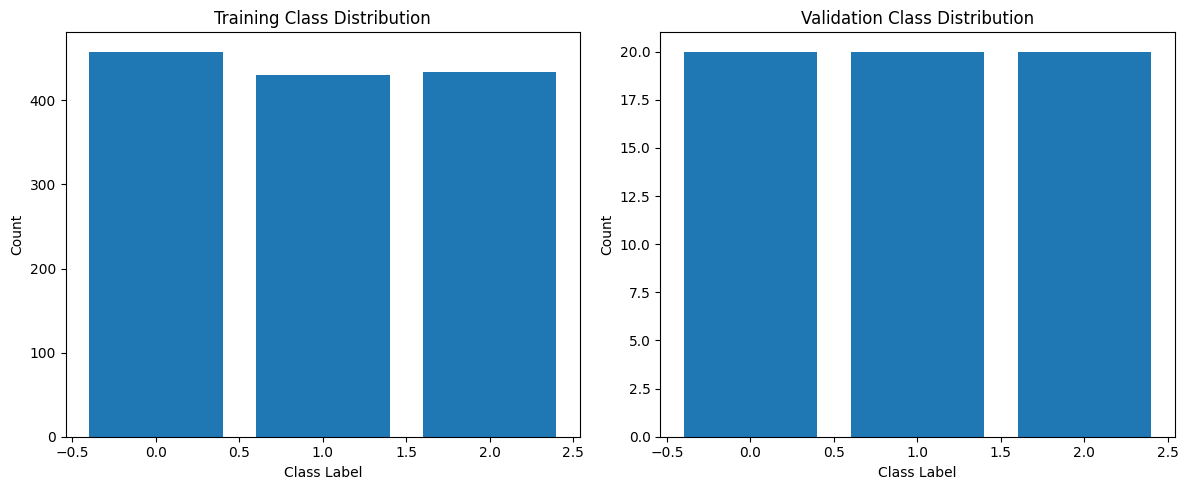

In [6]:
# Check class distribution in the training dataset
train_class_count = train_dataset.classes
train_class_count_dict = {
    class_label: list(train_class_count).count(class_label)
    for class_label in range(len(train_dataset.class_indices))
}
print("Training Class Distribution:", train_class_count_dict)

# Check class distribution in the validation dataset
valid_class_count = valid_dataset.classes
valid_class_count_dict = {
    class_label: list(valid_class_count).count(class_label)
    for class_label in range(len(valid_dataset.class_indices))
}
print("Validation Class Distribution:", valid_class_count_dict)

# Plotting the class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(train_class_count_dict.keys(), train_class_count_dict.values())
axes[0].set_title("Training Class Distribution")
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Count")

axes[1].bar(valid_class_count_dict.keys(), valid_class_count_dict.values())
axes[1].set_title("Validation Class Distribution")
axes[1].set_xlabel("Class Label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

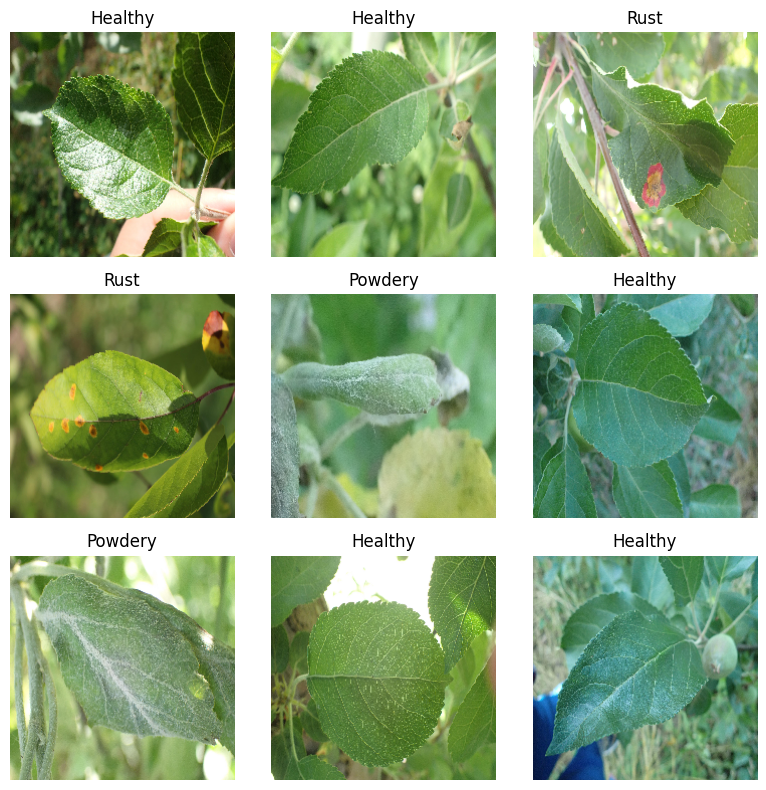

In [7]:
import matplotlib.pyplot as plt

images, labels = train_dataset.next()
class_names = list(train_dataset.class_indices.keys())

# Create a 3x3 grid to display the images
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(
        class_names[labels[i].argmax()]
    )  # Show the corresponding class label as the title
    plt.axis("off")  # Hide axes
plt.tight_layout()
plt.show()

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Dropout,
    BatchNormalization,
    Activation,
)
from tensorflow.keras.models import Model

# Load ResNet50 model without including the top fully-connected layers
IMG_SHAPE = IMG_SIZE + (3,)
base_model = ResNet50(input_shape=IMG_SHAPE, weights="imagenet", include_top=False)

base_model.trainable = False

In [9]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Dense layers
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)


predictions = Dense(3, activation="softmax")(x)


# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
base_learning_rate = 0.0001


model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
    ],
)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)


# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [14]:
train_steps = train_dataset.samples // BATCH_SIZE
valid_steps = valid_dataset.samples // BATCH_SIZE

# Train the model
history = model.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=train_steps,
    validation_data=valid_dataset,
    validation_steps=valid_steps,
    callbacks=[early_stopping, LearningRateScheduler(lr_scheduler)],
)

Epoch 1/100
41/41 [==============================] - 148s 3s/step - loss: 1.2320 - accuracy: 0.3837 - precision: 0.4009 - recall: 0.2163 - auc: 0.5530 - val_loss: 1.1532 - val_accuracy: 0.4062 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6001 - lr: 1.0000e-04
Epoch 2/100
41/41 [==============================] - 123s 3s/step - loss: 1.0674 - accuracy: 0.4775 - precision: 0.5173 - recall: 0.3240 - auc: 0.6647 - val_loss: 1.2104 - val_accuracy: 0.3125 - val_precision: 0.3226 - val_recall: 0.3125 - val_auc: 0.5371 - lr: 1.0000e-04
Epoch 3/100
41/41 [==============================] - 129s 3s/step - loss: 0.9891 - accuracy: 0.5225 - precision: 0.5836 - recall: 0.3868 - auc: 0.7157 - val_loss: 1.2366 - val_accuracy: 0.3125 - val_precision: 0.3226 - val_recall: 0.3125 - val_auc: 0.5308 - lr: 1.0000e-04
Epoch 4/100
41/41 [==============================] - 124s 3s/step - loss: 0.9568 - accuracy: 0.5612 - precision: 0.6208 - recall: 0.4403 - auc: 0.7420 - val_loss: 1.2007 - v

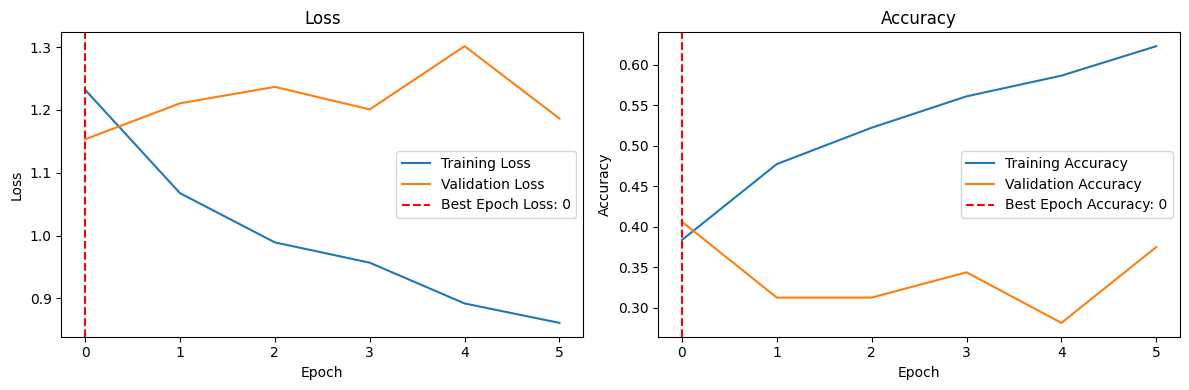

In [15]:
# Plot training history for loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Mark the best epoch for validation loss
best_epoch_loss = np.argmin(history.history["val_loss"])
plt.axvline(
    x=best_epoch_loss,
    color="r",
    linestyle="--",
    label=f"Best Epoch Loss: {best_epoch_loss}",
)
plt.legend()

# Plot training history for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Mark the best epoch for validation accuracy
best_epoch_accuracy = np.argmax(history.history["val_accuracy"])
plt.axvline(
    x=best_epoch_accuracy,
    color="r",
    linestyle="--",
    label=f"Best Epoch Accuracy: {best_epoch_accuracy}",
)
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Print the best epochs
print(f"Best Epoch for Validation Loss: {best_epoch_loss}")
print(f"Best Epoch for Validation Accuracy: {best_epoch_accuracy}")
print(f"Best Epoch for Validation Accuracy: {best_epoch_accuracy}")

Best Epoch for Validation Loss: 0
Best Epoch for Validation Accuracy: 0
Best Epoch for Validation Accuracy: 0


In [17]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(
    valid_dataset
)
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation AUC: {val_auc}")

2/2 [==============================] - 6s 2s/step - loss: 1.1424 - accuracy: 0.4333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6294
Validation Accuracy: 0.4333333373069763
Validation Precision: 0.0
Validation Recall: 0.0
Validation AUC: 0.6293749809265137


5/5 [==============================] - 17s 3s/step


TypeError: Invalid shape (32, 224, 224, 3) for image data

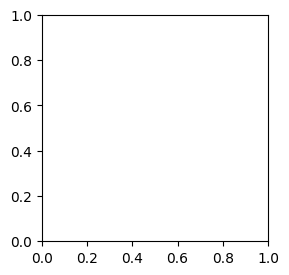

In [18]:
# Get predictions on the test dataset
predictions = model.predict(test_dataset)

# Create a subplot for a 3x3 grid of images
plt.figure(figsize=(10, 10))
for i in range(9):  # Display predictions for the first 9 samples
    plt.subplot(3, 3, i + 1)

    # Get image, true label, predicted probabilities, and class names
    image, label = test_dataset[i]  # Fetch the image and label from the test dataset
    image = np.squeeze(image)  # Remove the batch dimension if present
    true_label = np.argmax(label)
    predicted_probabilities = predictions[i]
    class_names = list(test_dataset.class_indices.keys())

    # Show the image
    plt.imshow(image)
    predicted_label = np.argmax(predicted_probabilities)
    plt.title(
        f"True: {class_names[true_label]}\nPredicted: {class_names[predicted_label]}\nProb: {max(predicted_probabilities):.2f}"
    )
    plt.axis("off")

plt.tight_layout()
plt.show()